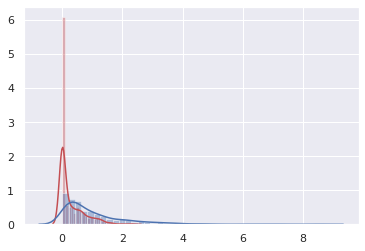

In [13]:
import seaborn as sns, numpy as np
sns.set(); np.random.seed(0)
# x = np.random.exponential(size=1000) * 100
ax = sns.distplot(x,color='r')
sns.set(); np.random.seed(0)
y = np.random.exponential(size=1000)
ax = sns.distplot(y,color='b')

In [8]:
import seaborn as sns, numpy as np
from numpy import hstack, zeros, ones
from numpy.random import rand, randn, exponential
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from matplotlib import pyplot
import tensorflow as tf

def define_generator(latent_dim, n_outputs=1000):
    model = Sequential()
    model.add(Dense(500, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='relu'))
    return model

def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

def generate_real_samples(n):
    x = np.zeros((n,1000))
    for i in range(n):
        x[i] = np.random.exponential(size=1000) * 100
    # generate class labels
    y = np.ones((n, 1))
    return x, y

def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y
with tf.device('/device:GPU:1'):
    latent_dim = 5

    model = define_generator(latent_dim)

    x,y=generate_fake_samples(model,latent_dim,1)

In [10]:
x.shape

(1, 1000)

## Generate 100 * exp distribution

In [51]:
# train a generative adversarial network on a one-dimensional function
import seaborn as sns, numpy as np
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn, exponential
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization
from matplotlib import pyplot
import tensorflow as tf
from numpy.random import random, choice
# define the standalone discriminator model
def define_discriminator(n_inputs=1500):
    model = Sequential()
    model.add(Dense(500, kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=1500):
    model = Sequential()
    model.add(Dense(500, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1000))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(n_outputs))
    model.add(LeakyReLU(alpha=0.1))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# generate n real samples with class labels
def generate_real_samples(n):
    x = np.zeros((n,1500))
    for i in range(n):
        x[i] = np.random.exponential(size=1500) * 100
    # generate class labels
    y = np.ones((n, 1))
    return x, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    sns.set()
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    # scatter plot real and fake data points
    sns.distplot(x_real[0],color='r')
    sns.distplot(x_fake[0],color='b')
    file = str(epoch)+'.png'
    pyplot.savefig(file)
    pyplot.close()

def smooth_positive_labels(y):
    return y - 0.3 + (random(y.shape) * 0.5)
def smooth_negative_labels(y):
    return y + 0.3 + (random(y.shape) * 0.3)


# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=50000, n_batch=5000, n_eval=2000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        y_real = smooth_positive_labels(y_real)
        y_fake = smooth_negative_labels(y_fake)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        y_gan = smooth_positive_labels(y_gan)
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

with tf.device('/device:GPU:1'):

    # size of the latent space
    latent_dim = 150
    # create the discriminator
    discriminator = define_discriminator()
    # create the generator
    generator = define_generator(latent_dim)
    # create the gan
    gan_model = define_gan(generator, discriminator)
    # train model
    train(generator, discriminator, gan_model, latent_dim)

1999 0.9900000095367432 0.9100000262260437


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3999 1.0 0.8100000023841858


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5999 0.9900000095367432 0.6800000071525574


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7999 1.0 0.7699999809265137


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9999 1.0 0.949999988079071


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11999 1.0 0.4699999988079071


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


13999 0.9100000262260437 0.7400000095367432


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


15999 1.0 0.6800000071525574


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


17999 0.8899999856948853 0.8799999952316284


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


19999 1.0 0.7599999904632568


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


21999 0.25 0.9900000095367432


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


23999 0.9900000095367432 0.38999998569488525


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


25999 0.9300000071525574 0.4099999964237213


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


27999 0.9599999785423279 0.28999999165534973


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


29999 0.9599999785423279 0.09000000357627869


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


31999 0.9900000095367432 0.05999999865889549


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


33999 0.9599999785423279 0.10000000149011612


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


35999 0.9599999785423279 0.07000000029802322


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


37999 0.9900000095367432 0.019999999552965164


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


39999 0.9399999976158142 0.07000000029802322


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


41999 0.9700000286102295 0.09000000357627869


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


43999 0.949999988079071 0.07999999821186066


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


45999 0.9800000190734863 0.05000000074505806


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


47999 0.9700000286102295 0.09000000357627869


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


49999 0.9800000190734863 0.05000000074505806


In [ ]:
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

x=generate_latent_points(100,1)
with tf.device('/device:GPU:1'):
    generator.predict(x)

## From left to right and from top to bottom. 

In [71]:
from IPython.display import Image, HTML, display
from glob import glob
# li=['normal/2999.png','normal/5999.png','normal/8999.png','normal/11999.png','normal/14999.png','normal/17999.png',
#   'normal/20999.png','normal/23999.png','normal/26999.png','normal/29999.png','normal/32999.png','normal/35999.png',
#   'normal/38999.png','normal/41999.png','normal/44999.png','normal/47999.png','normal/50999.png','normal/53999.png',
#   'normal/56999.png','normal/59999.png']
# li=[ '1999.png','3999.png', '5999.png',
#  '7999.png',
#  '9999.png','11999.png',
#  '13999.png',
#  '15999.png',
#  '17999.png', '19999.png',
#  '21999.png',
#  '23999.png',
#  '25999.png',
#  '27999.png',
#  '29999.png',
#  '31999.png',
#  '33999.png',
#  '35999.png',
#  '37999.png','39999.png',
#  '41999.png',
#  '43999.png',
#  '45999.png',
#  '47999.png',
#  '49999.png',]
imagesList=''.join( ["<img style='width: 360px; margin: 5px; float: left; border: 0px solid black;' src='%s' />" % str(s) 
                     for s in li ])
display(HTML(imagesList))

In [72]:
li=[ '1999.png','3999.png', '5999.png',
 '7999.png',
 '9999.png','11999.png',
 '13999.png',
 '15999.png',
 '17999.png', '19999.png',
 '21999.png',
 '23999.png',
 '25999.png',
 '27999.png',
 '29999.png',
 '31999.png',
 '33999.png',
 '35999.png',
 '37999.png','39999.png',
 '41999.png',
 '43999.png',
 '45999.png',
 '47999.png',
 '49999.png',]

In [73]:
import os
index=0
for i in li:
    j='normal/'+i
    li[index]=j
    index+=1

In [68]:
li

['1999.png',
 '3999.png',
 '5999.png',
 '7999.png',
 '9999.png',
 '11999.png',
 '13999.png',
 '15999.png',
 '17999.png',
 '19999.png',
 '21999.png',
 '23999.png',
 '25999.png',
 '27999.png',
 '29999.png',
 '31999.png',
 '33999.png',
 '35999.png',
 '37999.png',
 '39999.png',
 '41999.png',
 '43999.png',
 '45999.png',
 '47999.png',
 '49999.png']